<a href="https://colab.research.google.com/github/atonui/makemore/blob/main/building_micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=1&t=493s&ab_channel=AndrejKarpathy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [3]:
def f(x):
  return 3*x**2 - 4*x + 5

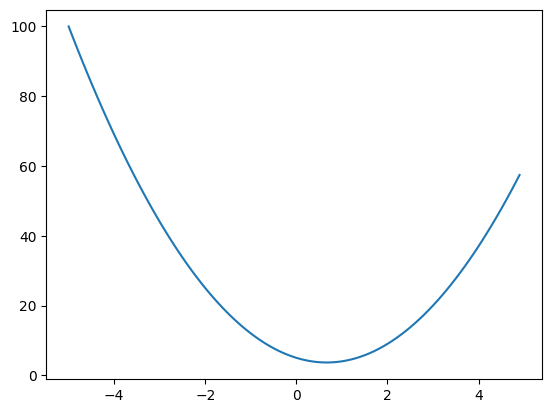

In [4]:
xs = np.arange(-5, 5, 0.1)
ys = f(xs)
plt.plot(xs, ys)

## What is a Deivative?

$$L = \lim_{x \to 0} \frac{f(a+h) - f(a)}{h}$$

If I slightly increase or decrease $f(a)$ how much does it change? What is it's sensitivity? Does it go up or down and by how much?

In [5]:
h = 0.0001 # a small change
x = 3
print(f(x))
print(f(x + h))
print((f(x + h) - f(x))/h)

20
20.001400030000006
14.000300000063248


In [6]:
h = 0.0001 # a small change
x = -3
print(f(x))
print(f(x + h))
print((f(x + h) - f(x))/h)

44
43.99780002999999
-21.999700000066014


In [7]:
h = 0.0001 # a small change
x = 2/3
print(f(x))
print(f(x + h))
print((f(x + h) - f(x))/h)

3.666666666666667
3.666666696666667
0.0002999999981767587


In [8]:
# a more complicated funtion
a = 2.0
b = -3.0
c = 10.0

d = a*b + c
print(d)

4.0


In [9]:
# applying the derivative to find out the effect of each variable on d
# a
h = 0.0001

a+=h
d1 = a*b + c
slope = (d1 - d)/(h)
print('d1: ', d)
print('slope: ', slope)

d1:  4.0
slope:  -3.000000000010772


Increasing $a$ by a small amount results in decreasing $d$ by -3.

In [10]:
# b
a = 2.0
b = -3.0
c = 10.0

d = a*b + c

b+=h
d2 = a*b + c
slope2 = (d2 - d)/(h)
print('d2: ', d2)
print('slope: ', slope2)

d2:  4.0002
slope:  2.0000000000042206


increasing $b$ by a asmall amount results in increasing $d$ by 2.

In [11]:
# c
a = 2.0
b = -3.0
c = 10.0

d = a*b + c

c+=h
d3 = a*b + c
slope3 = (d3 - d)/(h)
print('d3: ', d3)
print('slope: ', slope3)

d3:  4.0001
slope:  0.9999999999976694


Increasing $c$ by a small amount results in increasing $d$ by 1.

## Data Structure to Hold a Neuron

In [12]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 # derivative of the output, L wrt this variable
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    '''print out a nice looking expression rather that the memory address'''
    return f"Value(Data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      '''since this is a '+' node, the local gradient wrt to the output is 1,
      then we multiply by the gradient(effect) of the gradient being
      propagated backwards all the way from the output'''
      self.grad += 1.0 * out.grad # += is to accumulate the gradients rather than set them outright as using the same variable more than once will overide what was initially set
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __radd__(self, other):
    return self + other

  def __mul__(self, other):
    '''performs a multiplication function'''
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      '''returns the functions gradient'''
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other):
    '''fallback multiplication function'''
    return self * other

  def __pow__(self, other):
    '''performs a power function'''
    assert isinstance(other, (int, float)), "only supporting int or float powers"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      '''returns the functions gradient'''
      self.grad += other * (self.data**(other-1)) * out.grad
    out._backward = _backward
    return out

  def __truediv__(self, other):
    '''performs a division'''
    other = other if isinstance(other, Value) else Value(other)
    self = self if isinstance(self, Value) else Value(self)
    return self * other**-1

  def __neg__(self):
    '''returns the negative of the value'''
    return self * -1

  def __sub__(self, other):
    '''performs a subtraction'''
    return self + (-other)

  def exp(self):
    '''performs an exponential function'''
    x = self.data
    out = Value(np.exp(x), (self, ), 'exp')

    def _backward():
      '''returns the functions gradient'''
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (np.exp(2*x) - 1) / (np.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      '''returns the functions gradient'''
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def backward(self):
     '''autogradient function'''
     # first we build a topographical map of the nodes
     topo = []
     visited = set()
     def build_topo(v):
       if v not in visited:
         visited.add(v)
         for child in v._prev:
           build_topo(child)
         topo.append(v)
     build_topo(self)
     # base case is that the output node has a gradient of 1
     self.grad = 1.0
     # call the gradient function on each node in reverse
     for node in reversed(topo):
       node._backward()

In [13]:
a = Value(3.0, label='a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

NameError: name 'draw_dot' is not defined

In [ ]:
9-a

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
a + b # a.add(b)
d = e + c ; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

In [ ]:
print(d._prev)
print(d._op)

### Visualiser

In [14]:
# a way to visualise the mathematical expressions
from graphviz import Digraph

def trace(root):
  '''build a set of all nodes in a graph
  accepts an instance of the class Value
  and returns a set of all its node and edges'''
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # left to right
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this values is the result of some operation, create an op node for it
      dot.node(name=uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
     # connect n1 to the op node of n2
     dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
draw_dot(L)

This diagram above is our forward propagation. For the backpropagation, we have to find the derivative of all the terms wrt L

In [ ]:
L.grad = 1.0 # derivative of L wrt to itself is 1

$$L = d*f$$
$$\frac{dL}{dd} = f$$
$$\frac{dL}{df} = d$$

In [ ]:
# from above
f.grad = d.data
d.grad = f.data

$$d = c+e$$\
$$\frac{dd}{dc} = 1$$\
$$\frac{dd}{de} = 1$$

The derivative of a sum is one.

But how does $c$ or $e$ affect $L$?

Chain rule:
$$\frac{dz}{dx} = \frac{dz}{dy} * \frac{dy}{dx} \: ∴ $$ \
$$\frac{dL}{dc} = \frac{dL}{dd} * \frac{dd}{dc}$$ \
$$= f*1 = f$$ \
and:
$$\frac{dL}{de} = \frac{dL}{dd} * \frac{dd}{de}$$ \
$$= f*1 = f$$ \
Therfore we can conclude that a '+' node just routes backwards the gradient through because the local derivatives in a '+' node are always 1 i.e. it will distribute the incoming derivative to all it's children nodes.

In [ ]:
# from above
c.grad = f.data
e.grad = f.data

$$e=a*b$$ \
$$\frac{de}{da}=b=-3.0$$ \
$$\frac{dL}{da} = \frac{dL}{de} * \frac{dd}{de}$$ \
$$\frac{dL}{de}=f=-2.0$$ \
$$\frac{de}{da}=b=-3.0$$


In [ ]:
draw_dot(L)

In [ ]:
a.grad = (f.data * b.data)
b.grad = (f.data * a.data)

Now we know the effect of each node on L, let's nudge each input by a fraction of its gradient and see if L will decrease a little.

In [ ]:
# a.data += 0.1*a.grad
# b.data += 0.01*b.grad
# c.data += 0.01*c.grad
f.data += 0.1*f.grad

# run the forward pass again
e = a*b
d = e + c
L = d*f

L.data

In [ ]:
def lol():
  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label='e'
  a + b # a.add(b)
  d = e + c ; d.label='d'
  f = Value(-2.0, label='f')
  L = d*f; L.label='L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0+h, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label='e'
  a + b # a.add(b)
  d = e + c ; d.label='d'
  f = Value(-2.0, label='f')
  L = d*f; L.label='L'
  L2 = L.data

  print((L2-L1)/h)
lol()

### Backpropagation through a neuron
- Backpropagation using a more complex structure, the neuron.
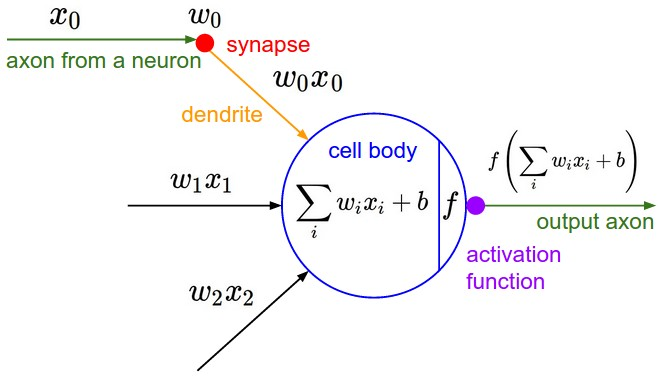

#### Tanh Activation Funciton
- Applied to the output of every neuron.

In [ ]:
plt.grid()
plt.title('tanh')
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))

### Simple MLP

In [ ]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'; o.grad = 1

In [ ]:
draw_dot(o)

### Manual Backpropagation
#### Tanh
$$\frac{do}{dn} = \frac{d}{dx} tanh(x) = 1 - tanh^{2}(x)$$
$$= 1 -o^2$$

In [ ]:
n.grad = 1 - (o.data**2)

In [ ]:
# since the '+' node just backpropagates the derivative through it:
b.grad = n.grad
x1w1x2w2.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

# at the '*' node
x2.grad = w2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w2.grad = x2.data * x2w2.grad
w1.grad = x1.data * x1w1.grad

### Automatic Backpropagation

In [ ]:
# redefine and redraw the MLP
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o';
o.backward()
draw_dot(o)

Break up the $tanh$ and redo the MLP

In [ ]:
# redefine and redraw the MLP
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ------------------
e = (2*n).exp()
o = (e-1)/(e+1)
# -----------------
o.backward()
draw_dot(o)

In [ ]:
o.backward()

In [ ]:
draw_dot(o)

In [ ]:
# now we call the backpropagation functions in the correct reverse order
o.grad = 1 # initialise the base case because in the Values class, this is initialised to 0
o._backward()
draw_dot(o)

In [ ]:
n._backward()
draw_dot(o)

In [ ]:
x1w1x2w2._backward()
draw_dot(o)

In [ ]:
x1w1._backward()
x2w2._backward()
draw_dot(o)

- Note: we do not call the backpropagate function on the leaf nodes like b.
The next thing is to automate this process so that we do not have to manually call the backpropagation.
- To chieve this, we can organise the nodes in a topographical map so that all th nodes have to go from left to right.

In [ ]:
o.grad = 1.0
for node in reversed(sorted):
  node._backward()

In [ ]:
draw_dot(o)

In [ ]:
# topological sort
def topo_sort(v):
  topo = [] # empty list to contain the sorted elements
  visited = set() # set of all nodes with no incoming edge

  def build_topo(v):
    # start the sort at root node v
    if v not in visited:
      visited.add(v)
      for child in v._prev:
        build_topo(child)
        # after a going through all the children in a node, we add it to the sorted list
        topo.append(v)
  build_topo(v) # call the helper function to start the sort
  return topo

In [ ]:
sorted = topo_sort(o)
print(sorted)

In [ ]:
sorted2 = topo_sort(n)
print(sorted2)
for node in sorted2:
  print(node.label)

In [ ]:
build_topo(x1w1x2w2)
topo

In [ ]:
for node in topo:
  print(node.label)

In [ ]:
for child in n._prev:
  print(child._prev,'\n')

In [ ]:
for child in o._prev:
  print(child._prev,'\n')

# Pytorch Implementation

In [ ]:
import torch
x1 = torch.Tensor([2.0]).double()                     ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                     ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                    ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                     ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()       ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()

print('-------------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

# Neural Network Implementation

In [15]:
class Neuron:
  '''class to define a single neuron and its properties'''

  def __init__(self, nin):
    '''nin -> number of inputs to each neuron'''
    self.w = [Value(np.random.uniform(-1,1)) for _ in range(nin)] # initialise the neuron with random weights for each input to the neuron
    self.b = Value(np.random.uniform(-1,1)) # initialise a random bias for each neuron

  def __call__(self, x):
    ''' w * x + b -> forward pass'''
    activation = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = activation.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

  def __repr__(self):
    return f"{' '.join(str(val) for val in self.w)} * {' + '.join(str(val) for val in x)} + {self.b}"

class Layer:
  '''class to define a layer of neurons.
     a layer of neurons is a set of neurons evaluated independently.'''

  def __init__(self, nin, non):
    '''nin -> number of inputs to each neuron
       non -> number of neurons in the layer'''
    self.neurons = [Neuron(nin) for _ in range(non)]

  def __call__(self, x):
    '''does the forward pass'''
    out = [n(x) for n in self.neurons]
    return out[0] if len(out) == 1 else out

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

  def __repr__(self):
    return f"{' '.join(str(val) for val in self.neurons)}"

class MLP:

  def __init__(self, nin, nons):
    '''nin -> number of inputs to each neuron
       nons -> list of the number of neurons per
              layer and it defines the sizes of all the
              layers we want in the MLP'''
    size = [nin] + nons
    self.layers = [Layer(size[i], size[i+1]) for i in range(len(nons))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [16]:
x = [2.0, 3.0] # 2 inputs to the neuron
n = Neuron(2) # initialise a neuron with 2 inputs
n

Value(Data=0.06916206394728497) Value(Data=-0.5937462422240745) * 2.0 + 3.0 + Value(Data=0.5409305496528118)

In [17]:
n(x) # call the neuron forward pass

Value(Data=-0.8012105637919879)

In [18]:
# create a layer of independent neurons connected to the same inputs
y = [2.0, 3.0] # 2 inputs to the neurons
l = Layer(2, 3) # a layer with 3 neurons and 2 inputs to each neuron
l

Value(Data=0.6467427089343494) Value(Data=0.39458269321068284) * 2.0 + 3.0 + Value(Data=-0.9927020004820968) Value(Data=-0.04216074662543545) Value(Data=0.9404218282971717) * 2.0 + 3.0 + Value(Data=0.5395191054538102) Value(Data=0.3471776305012777) Value(Data=0.4514021442736169) * 2.0 + 3.0 + Value(Data=0.06480344895848922)

In [19]:
# call the layer forward pass
l(y)

[Value(Data=0.902313528749901),
 Value(Data=0.9971521869634483),
 Value(Data=0.9712200870158599)]

In [48]:
# create an MLP of 3 input neurons, 2 hidden layers of 4 neurons each and one output neuron
mlp = MLP(3, [4, 4, 1])
mlp

In [49]:
z = [2.0, 3.0, -1.0] # 3 inputs to each neuron
mlp(z)

Value(Data=0.2892424069564171)

In [50]:
mlp.parameters()

[Value(Data=0.9012835038093203),
 Value(Data=0.6192485190969448),
 Value(Data=-0.6380808291630218),
 Value(Data=0.02774963763699745),
 Value(Data=-0.9899162506712249),
 Value(Data=-0.9304724787676142),
 Value(Data=-0.8064508999161661),
 Value(Data=-0.6889094878579354),
 Value(Data=-0.7794557460242002),
 Value(Data=-0.7304206351036033),
 Value(Data=0.047188891607171435),
 Value(Data=-0.32696847624555847),
 Value(Data=0.12434396332721698),
 Value(Data=-0.14712546050316244),
 Value(Data=0.15254569017616126),
 Value(Data=0.443285233758145),
 Value(Data=-0.8535122892918718),
 Value(Data=-0.9423528245636057),
 Value(Data=-0.7114507232998069),
 Value(Data=-0.29985339463288896),
 Value(Data=0.3053356274936456),
 Value(Data=0.9541580131220397),
 Value(Data=0.974637149456117),
 Value(Data=0.869877800715186),
 Value(Data=0.7755957394539412),
 Value(Data=-0.5356735615803305),
 Value(Data=-0.6668711808848289),
 Value(Data=-0.13447220353507383),
 Value(Data=-0.9990806322733967),
 Value(Data=0.848998

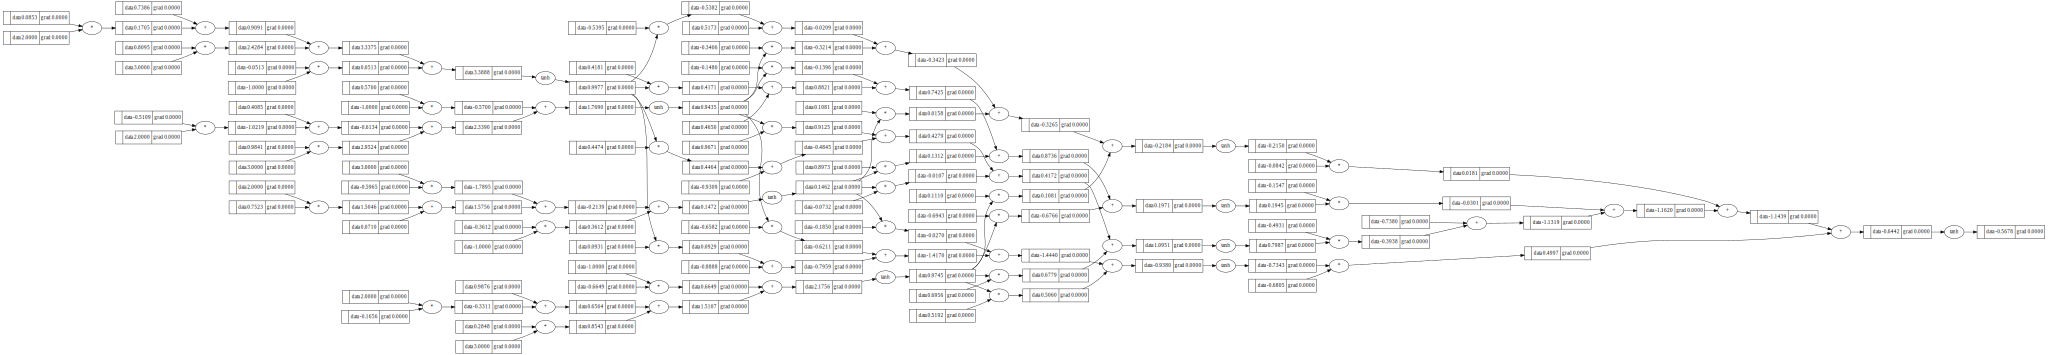

In [23]:
draw_dot(mlp(z))

In [51]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

## Loss

In [25]:
ypred = [mlp(x) for x in xs]
ypred

[Value(Data=-0.5677554693285594),
 Value(Data=-0.152129782918626),
 Value(Data=-0.44611884387439227),
 Value(Data=-0.5695252689450162)]

### Mean Squared Error
$(target - predicted)^2$

In [26]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(Data=5.946935021591193)

In [27]:
loss.backward()

In [28]:
mlp.layers[0].neurons[0].w[0].grad

np.float64(-0.2019226058590548)

In [29]:
mlp.layers[0].neurons[0].w[0].data

0.08525035780798951

In [30]:
for p in mlp.parameters():
  p.data += -0.05 * p.grad # the negative value is the learning rate

In [31]:
mlp.layers[0].neurons[0].w[0].data


np.float64(0.09534648810094225)

In [32]:
ypred = [mlp(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(Data=4.4232935067581)

In [47]:
ypred

[Value(Data=0.9742197206964573),
 Value(Data=-0.9994822639567557),
 Value(Data=-0.9988140700368271),
 Value(Data=0.9805439354581634)]

In [98]:
# amore respectable training loop
for k in range(20):
  # forward pass
  ypred = [mlp(x) for x in xs]
  loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

  # backpass
  for p in mlp.parameters():
    p.grad = 0
  loss.backward()

  # update parameters -> gradient descent
  for p in mlp.parameters():
    p.data += -0.05 * p.grad # the negative value is the learning rate

  print('Iteration: ', k, 'Loss: ', loss.data)

Iteration:  0 Loss:  0.004295461811056464
Iteration:  1 Loss:  0.004278713362840044
Iteration:  2 Loss:  0.004262090339637155
Iteration:  3 Loss:  0.00424559135159258
Iteration:  4 Loss:  0.00422921502921194
Iteration:  5 Loss:  0.004212960022991326
Iteration:  6 Loss:  0.0041968250030549525
Iteration:  7 Loss:  0.0041808086588006966
Iteration:  8 Loss:  0.004164909698553149
Iteration:  9 Loss:  0.0041491268492242685
Iteration:  10 Loss:  0.004133458855981197
Iteration:  11 Loss:  0.004117904481921194
Iteration:  12 Loss:  0.004102462507753434
Iteration:  13 Loss:  0.004087131731487669
Iteration:  14 Loss:  0.004071910968129283
Iteration:  15 Loss:  0.004056799049380902
Iteration:  16 Loss:  0.004041794823350193
Iteration:  17 Loss:  0.004026897154263714
Iteration:  18 Loss:  0.004012104922186939
Iteration:  19 Loss:  0.003997417022749668


In [99]:
ypred

[Value(Data=0.9717264817494101),
 Value(Data=-0.9773259741318647),
 Value(Data=-0.9600767164980005),
 Value(Data=0.9669841678306704)]

In [46]:
mlp.parameters()

[Value(Data=0.031001265159119246),
 Value(Data=-0.2936447619897306),
 Value(Data=0.11046115407272153),
 Value(Data=1.1061842059308042),
 Value(Data=-1.0990430415020258),
 Value(Data=-0.5313123490175966),
 Value(Data=-0.48163061331420337),
 Value(Data=-0.06478366626272704),
 Value(Data=-0.20805790525055065),
 Value(Data=0.6436742298845315),
 Value(Data=-1.0947519054005064),
 Value(Data=-0.37297940339276464),
 Value(Data=-0.12679646291509547),
 Value(Data=-1.1948931443022426),
 Value(Data=2.0533584988077282),
 Value(Data=-0.6654372180959399),
 Value(Data=0.34996532779098116),
 Value(Data=0.335375157371618),
 Value(Data=-0.02395216890927152),
 Value(Data=0.062012105972723434),
 Value(Data=-1.0695404367416164),
 Value(Data=0.2728129585496014),
 Value(Data=0.10286813893535549),
 Value(Data=-0.9821298755879865),
 Value(Data=-0.6040306548784532),
 Value(Data=0.3896667165727442),
 Value(Data=0.21246526250853467),
 Value(Data=0.8938351656523358),
 Value(Data=1.094330897694547),
 Value(Data=-0.7